<h1> FOOFing OMEGA - Parallel </h1>

This notebook runs FOOF on a matrix on PSDs from OMEGA. 
- Uses Pool from Multiprocessing to run FOOF in parallel
- Must Specify frequency range desired for FOOF
- Saves FOOF results in pickled object

In [34]:
# Import sys and add FOOF location to path
import sys
sys.path.append('/Users/thomasdonoghue/Documents/GitCode/')

# Import FOOF
from foof import syn
from foof.fit import FOOF

# Import Parallelization Packages
from multiprocessing import Pool, freeze_support

import matplotlib.pyplot as plt

# Import other packages
import os
import numpy as np
import scipy.io as sio
import pickle

%matplotlib inline

In [35]:
# Set Paths
meg_data_path = '/Users/thomasdonoghue/Documents/Research/1-Projects/OMEGA/2-Data/MEG/2-PSDs/Colin/'

In [44]:
# Check Availabe Subjects
files = os.listdir(meg_data_path)
files = clean_file_list(files, 'Subject_')
print files

['Subject_124340', 'Subject_220216', 'Subject_265922', 'Subject_320548', 'Subject_369737', 'Subject_390845', 'Subject_504997']


In [45]:
# Set subject number
subj = 504997

# Load Data
#matFile = 'Vertex_PSD_50Hz_' + str(subj) + '.mat'
matFile = 'psd_source_median_' + str(subj) + '.mat'
filename = os.path.join((meg_data_path + 'Subject_' + str(subj)), matFile)

# This pulls out the data in the matfile into a dictionary
dataMat = sio.loadmat(filename, appendmat=True, struct_as_record=False, squeeze_me=True)

# Pull out pieces from the dictionary
freqs = dataMat['Freqs']
psd = dataMat['TF']
labels = dataMat['RowNames']   # Scout names if scout data. Sensor/Vertex numbers if sensor/vertex

In [46]:
# Check data - get size
[nPSDs, nFreqs] = np.shape(psd)
freq_res = np.mean(np.diff(freqs))
print nPSDs
print freq_res

7500
0.488281250012


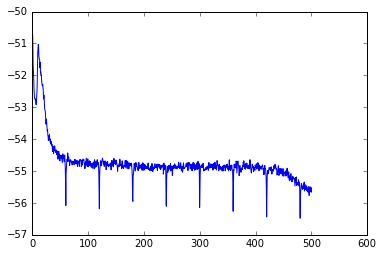

In [47]:
np.shape(psd)
plt.plot((freqs), np.log(psd[220, :]))

In [48]:
# Extract PSD range of interest

# Drop Freqs below 3
f_low_mask = freqs > 3
freqs_ext = freqs[f_low_mask]
psd_ext = psd[:, f_low_mask]

# Drop freqs above 40
f_high_mask = freqs_ext < 40
freqs_ext = freqs_ext[f_high_mask]
psd_ext = psd_ext[:, f_high_mask]

In [49]:
# Foof settings
min_p = 0.1
foof = FOOF(min_p = min_p, res = freq_res, fmin=freqs_ext.min(), fmax=freqs_ext.max())

# Set up PSD as list
psd_list = list(psd_ext)
for i in range(0, nPSDs):
    psd_list[i] = np.reshape(psd_list[i], [len(freqs_ext), 1])

In [50]:
def foof_par(psd):    
    # Fit FOOF
    foof.model(freqs_ext, psd)
    
    # Store vals in tuple and return
    return (foof.chi_, foof.centers_, foof.powers_, foof.stdevs_)

In [ ]:
# Open Pool, run FOOF in parallel, and then close pool. 
# Results stored in list of tuples"
pool = Pool(8)
results = pool.map(foof_par, psd_list[0:1])
pool.close()
pool.join()

# Use pickle to save the results
foof_data_path = '/Users/thomasdonoghue/Documents/Research/1-Projects/OMEGA/2-Data/MEG/3-FOOF/'
foof_save_name = str(subj) + '_Foof_Vertex.p'
foof_save_path = os.path.join(foof_data_path, foof_save_name)
pickle.dump(results, open(foof_save_path, 'wb'))

# Close the pool
pool.terminate()

In [1]:
def clean_file_list(files_in, string):
    
    files_out = []

    for i in range(0, len(files_in)):
        if(string in files_in[i]):
            files_out.append(files_in[i])
            
    return files_out

In [ ]:
# Parallel not working. Run linearly. 
results = [foof_par(psd) for psd in psd_list]

# Use pickle to save the results
foof_data_path = '/Users/thomasdonoghue/Documents/Research/1-Projects/OMEGA/2-Data/MEG/3-FOOF/'
foof_save_name = str(subj) + '_Foof_Vertex.p'
foof_save_path = os.path.join(foof_data_path, foof_save_name)
pickle.dump(results, open(foof_save_path, 'wb'))